In [1]:
!pip install keras==2.2.0

    100% |████████████████████████████████| 307kB 18.9MB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 27.6MB/s ta 0:00:01
tensorflow 1.13.1 has requirement keras-applications>=1.0.6, but you'll have keras-applications 1.0.2 which is incompatible.
tensorflow 1.13.1 has requirement keras-preprocessing>=1.0.5, but you'll have keras-preprocessing 1.0.1 which is incompatible.
  Found existing installation: Keras-Preprocessing 1.0.9
    Uninstalling Keras-Preprocessing-1.0.9:
      Successfully uninstalled Keras-Preprocessing-1.0.9
  Found existing installation: Keras-Applications 1.0.7
    Uninstalling Keras-Applications-1.0.7:
      Successfully uninstalled Keras-Applications-1.0.7
  Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
from __future__ import print_function, division

from keras.applications.vgg19 import VGG19
from keras.layers import Input, Dense, Flatten, Dropout, Reshape
from keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.optimizers import Adam
from keras import models
from keras import layers
from keras import optimizers

from keras.datasets import cifar10
import keras.backend as K
import tensorflow as tf
from tensorflow.python.keras import backend as K
from keras.models import load_model

import matplotlib.pyplot as plt

import sys
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
!pip install keras_vggface

    100% |████████████████████████████████| 61kB 7.1MB/s ta 0:00:011
    100% |████████████████████████████████| 61kB 29.2MB/s ta 0:00:01
  Stored in directory: /tmp/.cache/pip/wheels/72/aa/01/eb7baeb2f6e2d2f0d2aabddb5f01d57fa22fbd019ee2799bf5
Successfully built keras-vggface
keras 2.2.0 has requirement keras-applications==1.0.2, but you'll have keras-applications 1.0.7 which is incompatible.
keras 2.2.0 has requirement keras-preprocessing==1.0.1, but you'll have keras-preprocessing 1.0.9 which is incompatible.
  Found existing installation: Keras-Preprocessing 1.0.1
    Uninstalling Keras-Preprocessing-1.0.1:
      Successfully uninstalled Keras-Preprocessing-1.0.1
  Found existing installation: Keras-Applications 1.0.2
    Uninstalling Keras-Applications-1.0.2:
      Successfully uninstalled Keras-Applications-1.0.2
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
from keras_applications.imagenet_utils import _obtain_input_shape 


In [6]:
from keras_vggface import VGGFace

In [ ]:
  vgg_model = VGGFace(include_top=False, input_shape=(64, 64, 3))
  vgg_model.summary()

In [ ]:
  #vgg_model = VGG19(weights = "imagenet",include_top=False, input_shape=(64, 64, 3))

  #t=15
  #while t>0:
    #vgg_model.layers.pop()
    #t=t-1
  #vgg_model.summary()

In [59]:
def get_generator(input_layer):
 
  hid = Dense(128 * 16 * 16, activation='relu')(input_layer)    
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)
  hid = Reshape((16, 16, 128))(hid)

  hid = Conv2D(128, kernel_size=5, strides=1,padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)    
  #hid = Dropout(0.5)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2DTranspose(128, 4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2DTranspose(128, 4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  #hid = Dropout(0.5)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)
                      
  hid = Conv2D(3, kernel_size=5, strides=1, padding="same")(hid)
  out = Activation("tanh")(hid)

  model = Model(input_layer, out)
  model.summary()
  
  return model, out

In [60]:
def get_discriminator(input_layer):
  '''
  Requires the input layer as input, outputs the model and the final layer
  '''
  vgg_model = VGGFace(include_top=False, input_shape=(64, 64, 3))
  nb_class = 1
  hidden_dim = 512
  for layer in vgg_model.layers[:8]:
    layer.trainable=False
  last_layer = vgg_model.output
  x = Flatten(name='flatten')(last_layer)
  x = Dense(hidden_dim,name='fc6')(x)
  x = LeakyReLU(alpha=0.1)(x)
  #x = Dense(128,name='fc7')(x)
  #x = LeakyReLU(alpha=0.1)(x)
  out = Dense(nb_class, activation='sigmoid', name='fc8')(x)  

  model = Model(vgg_model.input, out)

  model.summary()

  return model, out

In [61]:
from keras.preprocessing import image

def generate_noise(n_samples, noise_dim):
  X = np.random.normal(0, 1, size=(n_samples, noise_dim))
  return X

def show_imgs(batchidx):
  noise = generate_noise(9, 100)
  gen_imgs = generator.predict(noise)

  fig, axs = plt.subplots(3, 3)
  count = 0
  for i in range(3):
    for j in range(3):
      img = image.array_to_img(gen_imgs[count], scale=True)
      axs[i,j].imshow(img)
      axs[i,j].axis('off')
      count += 1
  plt.show()
  plt.close()

In [62]:
# GAN creation
img_input = Input(shape=(64,64,3))
discriminator, disc_out = get_discriminator(img_input)
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

discriminator.trainable = False

noise_input = Input(shape=(100,))
generator, gen_out = get_generator(noise_input)

gan_input = Input(shape=(100,))
x = generator(gan_input)
gan_out = discriminator(x)
gan = Model(gan_input, gan_out)
gan.summary()

gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 64, 64, 64)        1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 64, 64, 64)        36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 32, 32, 128)       147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 16, 16, 128)       0         
__________

In [11]:
import os

In [12]:
# Data
BASE_PATH = "../input/celebrities-100k/"
print(os.listdir(BASE_PATH))
#BASE_PATH = base_PATH+ 'celebrities-100k' 
DATASET_LIST_PATH= BASE_PATH + "100k.txt"
print(DATASET_LIST_PATH)



['100k', '100k.txt']
../input/celebrities-100k/100k.txt


In [13]:
DATASET_LIST_PATH


'../input/celebrities-100k/100k.txt'

In [14]:
INPUT_DATA_DIR = BASE_PATH + "100k/100k/"


In [15]:
INPUT_DATA_DIR

'../input/celebrities-100k/100k/100k/'

In [16]:
OUTPUT_DIR = "./"


In [17]:
#MODEL_PATH = BASE_PATH + "models/" + "model_" + str(EPOCH) + ".ckpt"
DATASET = [INPUT_DATA_DIR + str(line).rstrip() for line in open(DATASET_LIST_PATH,"r")]

In [18]:
#model_path = '../input/facenet-keras/facenet_keras.h5'
#facenet = load_model(model_path)

In [19]:
#facenet.summary()

In [20]:
import scipy.misc
import scipy.ndimage

In [21]:
#uploading images from folder
images = []
for img_name in DATASET:
    image = scipy.ndimage.imread(img_name, mode="RGB")
    image_resized = scipy.misc.imresize(image,(64,64))
    images.append(image_resized)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


In [22]:
train_x = np.stack(images)

In [23]:
train_x.shape

(100000, 64, 64, 3)

In [24]:
X_train = train_x[:50000]

In [25]:
X_train = ((X_train)-127.5)/127.5

In [26]:
BATCH_SIZE = 320

# # Get training images
#(X_train, y_train), (X_test, _) = cifar10.load_data()

# S

# Normalize data
 
num_batches = int(X_train.shape[0]/BATCH_SIZE)

In [27]:
X_train.shape

(50000, 64, 64, 3)

In [40]:
import time

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


  Epoch: 1, Generator Loss: 14.594400086464026, Discriminator Loss: [7.2641664 0.       ]


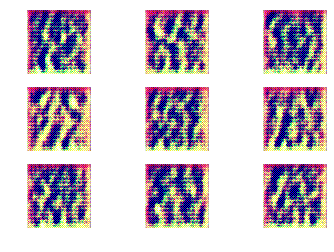

For epoch: 1, Time taken is: 203.64336681365967 seconds
  Epoch: 2, Generator Loss: 15.942384719848633, Discriminator Loss: [7.968644 0.      ]


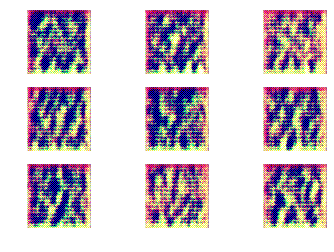

For epoch: 2, Time taken is: 183.86302518844604 seconds
  Epoch: 3, Generator Loss: 15.942384719848633, Discriminator Loss: [7.971188 0.      ]


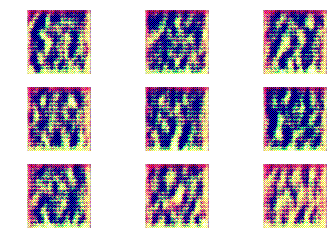

For epoch: 3, Time taken is: 183.30799102783203 seconds
  Epoch: 4, Generator Loss: 15.942384719848633, Discriminator Loss: [7.970264 0.      ]


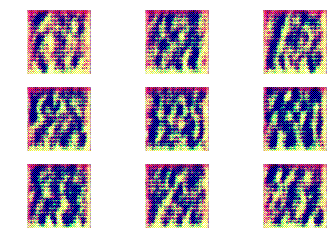

For epoch: 4, Time taken is: 183.59763026237488 seconds
  Epoch: 5, Generator Loss: 15.942384719848633, Discriminator Loss: [7.9707108 0.       ]


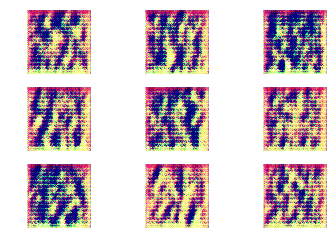

For epoch: 5, Time taken is: 183.4922263622284 seconds
  Epoch: 6, Generator Loss: 15.942384719848633, Discriminator Loss: [7.972596 0.      ]


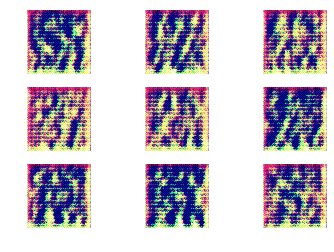

For epoch: 6, Time taken is: 183.51395869255066 seconds
  Epoch: 7, Generator Loss: 15.942384719848633, Discriminator Loss: [7.9725904 0.       ]


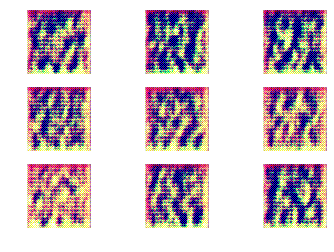

For epoch: 7, Time taken is: 183.04872250556946 seconds
  Epoch: 8, Generator Loss: 15.942384719848633, Discriminator Loss: [7.9703526 0.       ]


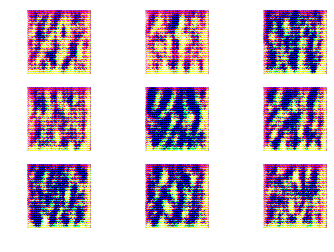

For epoch: 8, Time taken is: 183.89236903190613 seconds
  Epoch: 9, Generator Loss: 15.942384719848633, Discriminator Loss: [7.9733238e+00 1.0016026e-05]


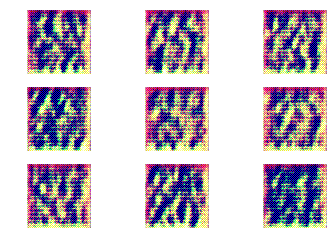

For epoch: 9, Time taken is: 184.00856947898865 seconds
  Epoch: 10, Generator Loss: 15.942384719848633, Discriminator Loss: [7.971936 0.      ]


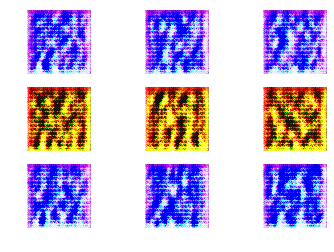

For epoch: 10, Time taken is: 183.06411695480347 seconds
  Epoch: 11, Generator Loss: 15.942384719848633, Discriminator Loss: [7.970532 0.      ]


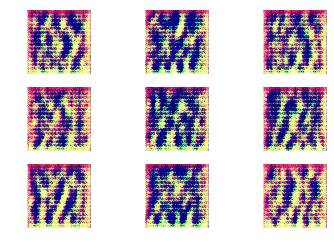

For epoch: 11, Time taken is: 183.15811347961426 seconds
  Epoch: 12, Generator Loss: 15.942384719848633, Discriminator Loss: [7.970074 0.      ]


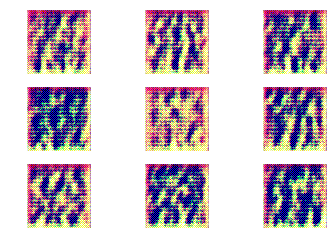

For epoch: 12, Time taken is: 183.92447209358215 seconds
  Epoch: 13, Generator Loss: 15.942384719848633, Discriminator Loss: [7.9704065 0.       ]


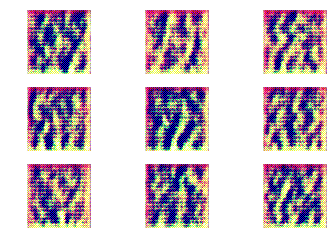

For epoch: 13, Time taken is: 184.76495337486267 seconds
  Epoch: 14, Generator Loss: 15.942384719848633, Discriminator Loss: [7.9707117 0.       ]


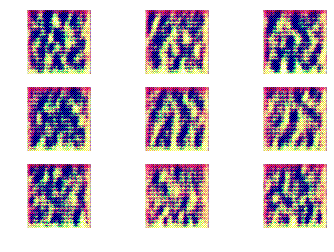

For epoch: 14, Time taken is: 183.65082025527954 seconds
  Epoch: 15, Generator Loss: 15.942384719848633, Discriminator Loss: [7.971617 0.      ]


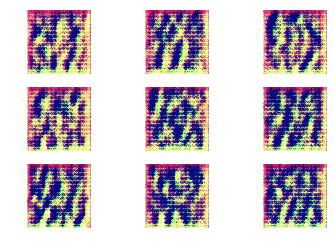

For epoch: 15, Time taken is: 182.91651701927185 seconds
  Epoch: 16, Generator Loss: 15.942384719848633, Discriminator Loss: [7.9735193 0.       ]


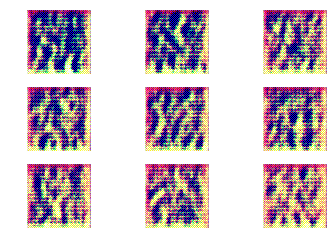

For epoch: 16, Time taken is: 182.8930594921112 seconds
  Epoch: 17, Generator Loss: 15.942384719848633, Discriminator Loss: [7.9716396 0.       ]


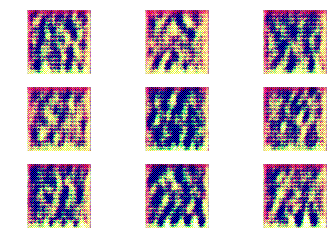

For epoch: 17, Time taken is: 182.77595591545105 seconds
  Epoch: 18, Generator Loss: 15.942384719848633, Discriminator Loss: [7.971757 0.      ]


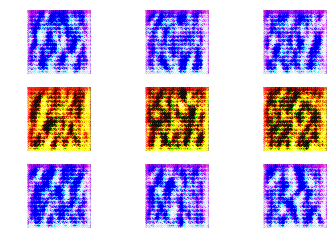

For epoch: 18, Time taken is: 183.52059388160706 seconds
  Epoch: 19, Generator Loss: 15.942384719848633, Discriminator Loss: [7.971266 0.      ]


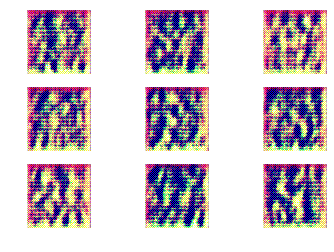

For epoch: 19, Time taken is: 183.1655728816986 seconds
  Epoch: 20, Generator Loss: 15.942384719848633, Discriminator Loss: [7.97102 0.     ]


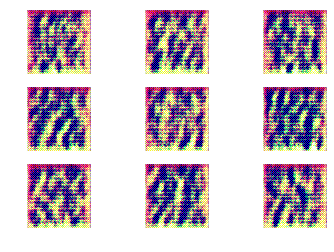

For epoch: 20, Time taken is: 183.71490454673767 seconds
  Epoch: 21, Generator Loss: 15.942384719848633, Discriminator Loss: [7.9731507 0.       ]


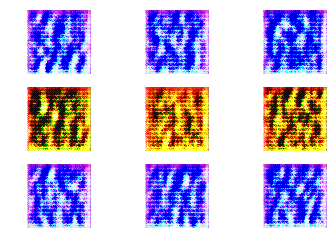

For epoch: 21, Time taken is: 182.8860583305359 seconds
  Epoch: 22, Generator Loss: 15.942384719848633, Discriminator Loss: [7.969414 0.      ]


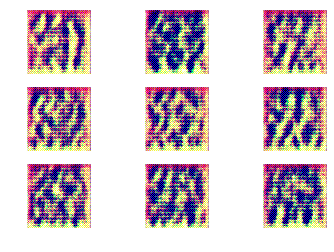

For epoch: 22, Time taken is: 183.33127760887146 seconds


KeyboardInterrupt: 

In [63]:
N_EPOCHS = 60
for epoch in range(N_EPOCHS):
  tic=time.time()
  cum_d_loss = 0.
  cum_g_loss = 0.
  
  for batch_idx in range(num_batches):
    # Get the next set of real images to be used in this iteration
    images = X_train[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]

    noise_data = generate_noise(BATCH_SIZE, 100)
    generated_images = generator.predict(noise_data)

    # Train on soft labels (add noise to labels as well)
    noise_prop = 0.05 # Randomly flip 5% of labels
    
    # Prepare labels for real data
    true_labels = np.zeros((BATCH_SIZE, 1)) + np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
    flipped_idx = np.random.choice(np.arange(len(true_labels)), size=int(noise_prop*len(true_labels)))
    true_labels[flipped_idx] = 1 - true_labels[flipped_idx]
    
    # Train discriminator on real data
    d_loss_true = discriminator.train_on_batch(images, true_labels)

    # Prepare labels for generated data
    gene_labels = np.ones((BATCH_SIZE, 1)) - np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
    flipped_idx = np.random.choice(np.arange(len(gene_labels)), size=int(noise_prop*len(gene_labels)))
    gene_labels[flipped_idx] = 1 - gene_labels[flipped_idx]
    
    # Train discriminator on generated data
    d_loss_gene = discriminator.train_on_batch(generated_images, gene_labels)

    d_loss = 0.5 * np.add(d_loss_true, d_loss_gene)
    cum_d_loss += d_loss
    # Train generator
    noise_data = generate_noise(BATCH_SIZE, 100)
    g_loss = gan.train_on_batch(noise_data, np.zeros((BATCH_SIZE, 1)))
    cum_g_loss += g_loss
    
  noise_data = generate_noise(BATCH_SIZE, 100)
  #generated_images = generator.predict(noise_data)
  print('  Epoch: {}, Generator Loss: {}, Discriminator Loss: {}'.format(epoch+1, cum_g_loss/num_batches, cum_d_loss/num_batches))
  show_imgs("epoch" + str(epoch))
  toc=time.time()
  print("For epoch: "+ str(epoch +1)+", Time taken is: " +str(toc-tic)+ " seconds")
  #print(discriminator.predict(generated_images))
